Gonna apply a random forest classifier algorithm to the new dataset

Import necessary libraries 

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree

#from sklearn.externals.six import StringIO  
from six import StringIO

from IPython.display import Image  
import pydotplus

print("complete")

complete


Read dataset

In [2]:
df = pd.read_csv("/Users/anthonyquint/Desktop/LHSC_Work_Folder/Mina/Bleeding_study/Ibrutinib Data Set, July 4,2021, de-identified data.csv")
df.head()

,Age at diagnosis,gender,Diagnosis year,Plt at diagnosis,plt at start of ibrutinib,plt at the time of bleed,Plt Nadir while on Ibrutinib,Platelets < 50 (Y/N),hb at diognosis,hb at start of Ibrutinib,...,action?,post op bleed? /action,INR,past medical history,PMHx bleeding risk (Y/N),Ibrutinib Dose,Comments,other ibrutinib SE,Unnamed: 44,Unnamed: 45
0,48,f,2006,260,15,NaN,15,Y,130,71,...,NaN,NaN,NaN,"deppression, schwanoma of leg",Y,"420mg,",ITP at the time of starting ibrutinib,NaN,NaN,NaN
1,66,m,2017,175,83,155,93,N,145,93,...,NaN,NaN,NaN,"cryoglobinemia,MGUS,CAD,HTN,COPD",N,420mg,NaN,NaN,NaN,NaN
2,74,F,2016,189,200,NaN,189,N,116,87,...,NaN,NaN,NaN,"dm2,htn,",N,"420mg,",reaction to first obino so switched to ibrutin...,NaN,NaN,NaN
3,53,F,2002,237,67,NaN,40,Y,135,118,...,NaN,NaN,NaN,"HTN,B12 def,IDA",N,420mg,WAIHA,easy bruising,NaN,NaN
4,60,m,1999,198,85,70,49,Y,154,104,...,died,NaN,1.1,"prostitis,mycosis,chronc sinusitis",N,ibrutinib dose reduced to 140 in oct 2015 for ...,"cutaneous oral mucosal involvement w CLL, als...",NaN,NaN,NaN


Cleaning the dataset

In [3]:
##Removing all columns except the columns corresponding to our relevant 
##independent variables (indicated at top of notebook) and dependent variable (Major Bleed (Y/N))

df = df[["Plt Nadir while on Ibrutinib","Anemia (hb < 100) (Y/N)","anticoagulation (Y/N)","Major Bleed (Y/N)"]]

## Selecting which two groups to compare, or comparing all three groups

## Major vs. Minor 
#df = df.dropna().copy() 

#Major vs. Minor + None bleeding
#changing NaN values in "Major Bleed (Y/N)" to N 
df['Major Bleed (Y/N)'].fillna('N', inplace=True)

#Major + Minor vs. None 
#changing "N" values to Y, and NaN values to N. 
#df['Major Bleed (Y/N)'] = df['Major Bleed (Y/N)'].replace(['N'],'Y')
#df['Major Bleed (Y/N)'].fillna('N', inplace=True)

#Major vs. None
#df = df[~df['Major Bleed (Y/N)'].isin(['N'])] 
#df['Major Bleed (Y/N)'].fillna('N', inplace=True)

#Minor vs. None
#df = df[~df['Major Bleed (Y/N)'].isin(['Y'])] 
#df['Major Bleed (Y/N)'] = df['Major Bleed (Y/N)'].replace(['N'],'Y')
#df['Major Bleed (Y/N)'].fillna('N', inplace=True)

#Major vs. minor vs. none 
# NOTE: IF I WANT TO DO THIS OPTION, I ALSO NEED TO ADJSUT THE UPSAMPLING TO THE MULTIOUTCOME UPSAMPLING (IT CURRENTLY ONLY UPSAMPLES BINOMIAL OUTCOMES). There'd also be more changes I'd have to make
#changing NaN values in "Major Bleed (Y/N)" to M. I.e. Y = major bleed, N = minor bleed, M = no bleed 
#df['Major Bleed (Y/N)'].fillna('M', inplace=True)

# Delete index 112 since it has a question mark for age 
df = df.drop(labels=112, axis=0)

df.head()

,Plt Nadir while on Ibrutinib,Anemia (hb < 100) (Y/N),anticoagulation (Y/N),Major Bleed (Y/N)
0,15,Y,N,N
1,93,Y,N,N
2,189,Y,N,N
3,40,N,N,N
4,49,N,N,Y


Counting number of people who had the types of bleeding. 

In [4]:
df['Major Bleed (Y/N)'].value_counts(dropna=False)

N    152
Y     17
Name: Major Bleed (Y/N), dtype: int64

Converting categorical data into numerical representation

In [5]:
number = LabelEncoder()

df['Anemia (hb < 100) (Y/N)'] = number.fit_transform(df['Anemia (hb < 100) (Y/N)'].astype('str'))
df['anticoagulation (Y/N)'] = number.fit_transform(df['anticoagulation (Y/N)'].astype('str'))
df['Major Bleed (Y/N)'] = number.fit_transform(df['Major Bleed (Y/N)'].astype('str'))

df.head()

,Plt Nadir while on Ibrutinib,Anemia (hb < 100) (Y/N),anticoagulation (Y/N),Major Bleed (Y/N)
0,15,1,0,0
1,93,1,0,0
2,189,1,0,0
3,40,0,0,0
4,49,0,0,1


Splitting data into independent and dependent variables, then into training and testing sets. 

In [6]:
clinical_features = ["Plt Nadir while on Ibrutinib","Anemia (hb < 100) (Y/N)","anticoagulation (Y/N)"]
#clinical_features = ["plt at the time of bleed","hb at the time of bleed","anticoagulation (Y/N)"]

X = df[clinical_features]   #Independent variables 
y = df['Major Bleed (Y/N)']  #Dependent variables 

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0,stratify=y) #Splitting variables into training/testing set

X_Y_train = pd.concat([X_train,y_train],axis=1)

def upsample_minority(df):
    
    df_majority = df.loc[df['Major Bleed (Y/N)'] == 0]
    df_minority = df.loc[df['Major Bleed (Y/N)'] == 1]
    
    df_minority_upsampled = resample(df_minority, replace = True, n_samples=len(df_majority), random_state=123)
    df_upsampled = pd.concat([df_majority,df_minority_upsampled])
    
    df = df_upsampled
    
    return df 

def smote(train_1,train_2):
    
    sm = SMOTE(random_state=27)
    train_1, train_2 = sm.fit_resample(train_1, train_2)
    
    return train_1,train_2 

#upsampling the minority directly
X_Y_train_upsample = upsample_minority(X_Y_train)
y_train_upsample = X_Y_train_upsample['Major Bleed (Y/N)']
X_train_upsample = X_Y_train_upsample.drop('Major Bleed (Y/N)', axis=1)

df_upsample = upsample_minority(df)
y_upsample = df_upsample['Major Bleed (Y/N)']
X_upsample = df_upsample.drop('Major Bleed (Y/N)', axis=1)

#upsampling by generating synthetic samples (smote)
X_train_smote, y_train_smote = smote(X_train, y_train)

X_smote, y_smote = smote(X, y)

# Choosing which of the 2 sets of upsampled data I'll make the model with (upsampling vs. smote). 
# Upsampling produces better results
XX = X_train_upsample
yy = y_train_upsample

## https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

Model Implementation/Performance metrics

In [7]:
rfc = RandomForestClassifier(n_estimators=10, max_depth=3).fit(XX, yy)

rfc_pred = rfc.predict(X_test)

accuracy_score(y_test, rfc_pred)
#f1_score(y_test, rfc_pred)
#recall_score(y_test, rfc_pred)

0.7906976744186046

In [8]:
confusion_matrix(y_test, rfc_pred)

array([[33,  6],
       [ 3,  1]])

In [11]:
print(classification_report(y_test, rfc_pred))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88        39
           1       0.14      0.25      0.18         4

    accuracy                           0.79        43
   macro avg       0.53      0.55      0.53        43
weighted avg       0.84      0.79      0.82        43



In [12]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
Plt Nadir while on Ibrutinib,0.701200
anticoagulation (Y/N),0.196801
Anemia (hb < 100) (Y/N),0.101999


Text(0.5, 1.0, 'Estimator: 4')

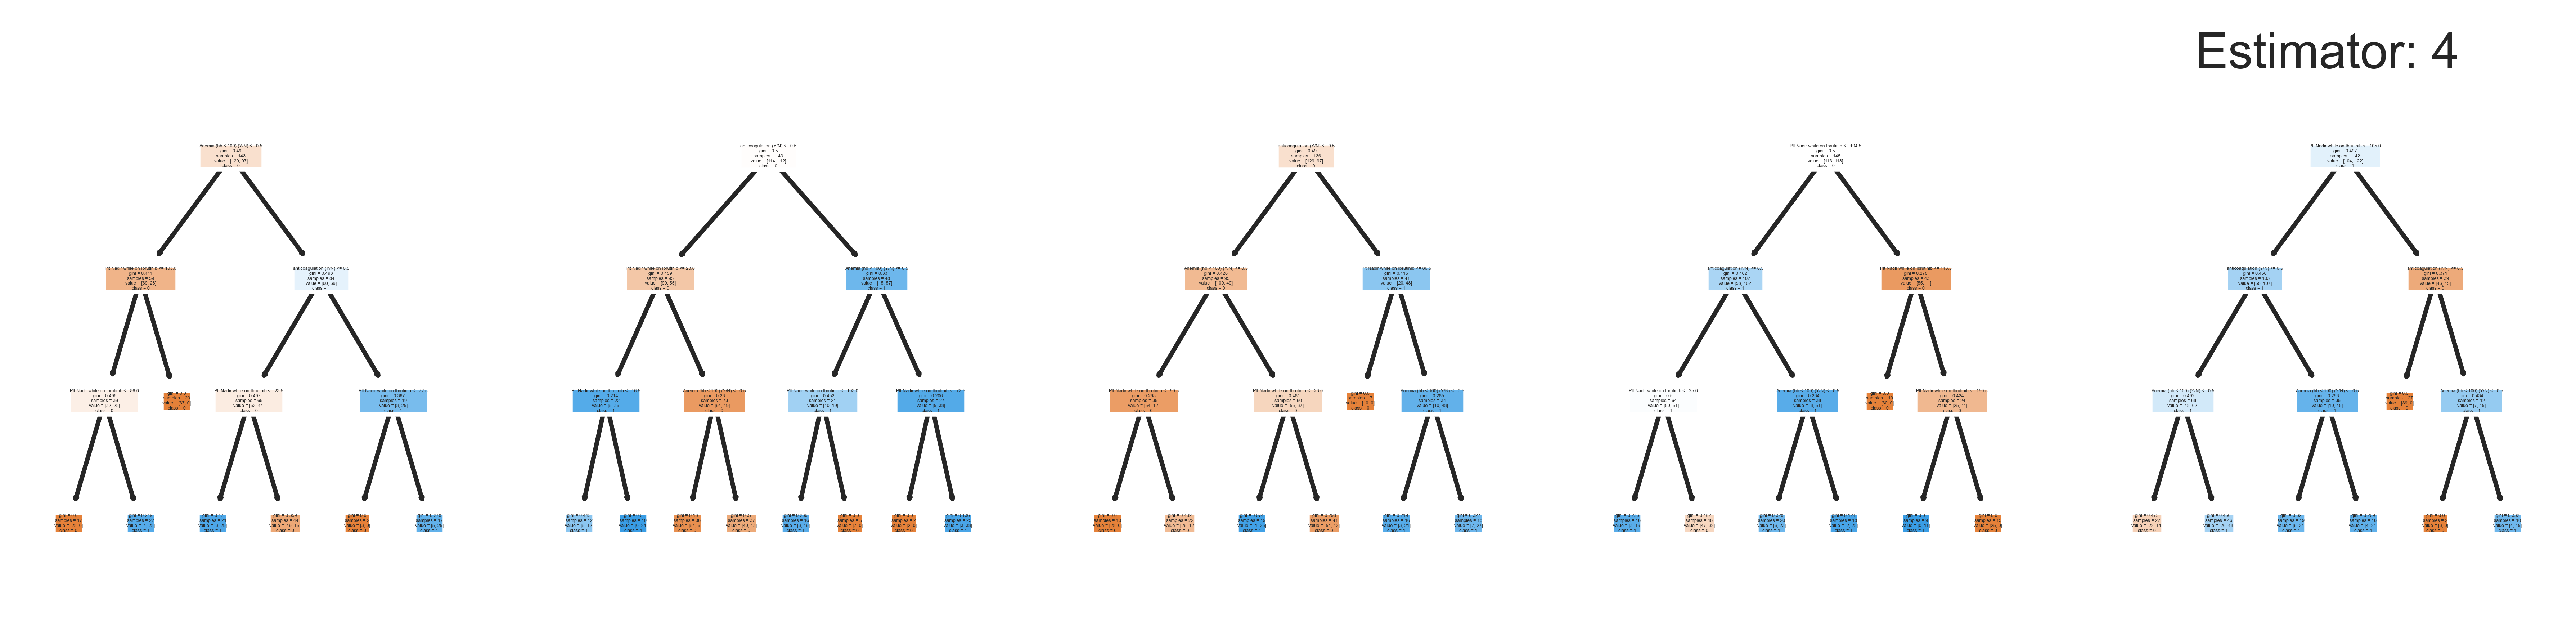

In [16]:
    # This may not the best way to view each estimator as it is small
fn = clinical_features
cn = ['0','1']
fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=900)
for index in range(0, 5):
        tree.plot_tree(rfc.estimators_[index],feature_names = fn, class_names=cn,filled = True,ax = axes[index]);

    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
    

# fig.savefig('rf_MajMinNone_NoSplit.png')  # saving figure 